Biostat/Biomath M257 Homework 2

subtitle: 'Due Apr 26 @ 11:59PM'

Tomoki Okuno and 805851067

System information (for reproducibility):

In [24]:
versioninfo()

Julia Version 1.10.2
Commit bd47eca2c8a (2024-03-01 10:14 UTC)
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: macOS (arm64-apple-darwin22.4.0)
  CPU: 8 × Apple M1
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-15.0.7 (ORCJIT, apple-m1)
Threads: 1 default, 0 interactive, 1 GC (on 4 virtual cores)
Environment:
  JULIA_NUM_THREADS = 
  DYLD_FALLBACK_LIBRARY_PATH = /Users/tomokiokuno/.julia/artifacts/5902919ba30b97bafa388ca950a351ea32516d26/lib:/Users/tomokiokuno/.julia/artifacts/92b949e2f3a66439c69a8d334fc95810fbd9df9b/lib:/Users/tomokiokuno/.julia/artifacts/5b338c8fa90c05e6faea86e54d2996cca76cfbbe/lib:/Users/tomokiokuno/.julia/juliaup/julia-1.10.2+0.aarch64.apple.darwin14/lib/julia:/Users/tomokiokuno/.julia/artifacts/0b234a64c0574e6156c740b15844963c0555164e/lib:/Users/tomokiokuno/.julia/artifacts/9410bad2635eda2239b4a72ba4316c4aa8f5b76e/lib:/Users/tomokiokuno/.julia/artifacts/a7cf2895cac9b6bec2c94e6490ca337e00b12894/lib:/Users/tomokiokuno/.julia/artifacts

Load packages:

In [25]:
using Pkg

Pkg.activate(pwd())
Pkg.instantiate()
Pkg.status()

  Activating project at `~/Documents/07_UCLA/Class/257/02_Homework/hw2`


Status `~/Documents/07_UCLA/Class/257/02_Homework/hw2/Project.toml`
  [6e4b80f9] BenchmarkTools v1.5.0
  [8bb1440f] DelimitedFiles v1.9.1
  [7073ff75] IJulia v1.24.2
  [86fae568] ImageView v0.12.1
  [916415d5] Images v0.26.1
  [bdcacae8] LoopVectorization v0.12.169
  [dde4c033] Metal v1.1.0
  [91a5bcdd] Plots v1.40.4
  [08abe8d2] PrettyTables v2.3.1
  [37e2e46d] LinearAlgebra
  [9abbd945] Profile


In [26]:
# load libraries
using BenchmarkTools, DelimitedFiles, Images, LinearAlgebra, LoopVectorization
using Profile, Random
using Plots

## Q1. Nonnegative Matrix Factorization

Nonnegative matrix factorization (NNMF) was introduced by [Lee and Seung (1999)](https://www.nature.com/articles/44565) as an alternative to principal components and vector quantization with applications in data compression, clustering, and deconvolution. In this homework we consider algorithms for fitting NNMF and (optionally) high performance computing using graphical processing units (GPUs).

<img src="./nnmf.png" width="500" align="center"/>

In mathematical terms, one approximates a data matrix $\mathbf{X} \in \mathbb{R}^{m \times n}$ with nonnegative entries $x_{ij}$ by a product of two low-rank matrices $\mathbf{V} \in \mathbb{R}^{m \times r}$ and $\mathbf{W} \in \mathbb{R}^{r \times n}$ with nonnegative entries $v_{ik}$ and $w_{kj}$. Consider minimization of the squared Frobenius norm
$$
L(\mathbf{V}, \mathbf{W}) = \|\mathbf{X} - \mathbf{V} \mathbf{W}\|_{\text{F}}^2 = \sum_i \sum_j \left(x_{ij} - \sum_k v_{ik} w_{kj} \right)^2, \quad v_{ik} \ge 0, w_{kj} \ge 0,
$$
which should lead to a good factorization. Lee and Seung suggest an iterative algorithm with multiplicative updates
$$
v_{ik}^{(t+1)} = v_{ik}^{(t)} \frac{\sum_j x_{ij} w_{kj}^{(t)}}{\sum_j b_{ij}^{(t)} w_{kj}^{(t)}}, \quad \text{where } b_{ij}^{(t)} = \sum_k v_{ik}^{(t)} w_{kj}^{(t)},
$$
$$
w_{kj}^{(t+1)} = w_{kj}^{(t)} \frac{\sum_i x_{ij} v_{ik}^{(t+1)}}{\sum_i b_{ij}^{(t+1/2)} v_{ik}^{(t+1)}}, \quad \text{where } b_{ij}^{(t+1/2)} = \sum_k v_{ik}^{(t+1)} w_{kj}^{(t)}
$$
that will drive the objective $L^{(t)} = L(\mathbf{V}^{(t)}, \mathbf{W}^{(t)})$ downhill. Superscript $t$ indicates the iteration number. In following questions, efficiency (both speed and memory) will be the most important criterion when grading this problem.

### Q1.1 Develop code

Implement the algorithm with arguments: $\mathbf{X}$ (data, each row is a vectorized image), rank $r$, convergence tolerance, and optional starting point.

**Solution**

Most importantly, we can rewrite the objective function for efficient calculation as
\begin{align*}
L(\mathbf{V}, \mathbf{W})
&= \|\mathbf{X} - \mathbf{V} \mathbf{W}\|_{\text{F}}^2 \\
&= \|\mathbf{X}\|_{\text{F}}^2 -2\text{tr}(\mathbf X'\mathbf V\mathbf W) + \text{tr}(\mathbf V'\mathbf V\mathbf W\mathbf W')\\
&= \|\mathbf{X}\|_{\text{F}}^2 -2\text{dot}(\mathbf W, \mathbf V'\mathbf X) + \text{dot}(\mathbf V'\mathbf V\mathbf W, \mathbf W).
\end{align*}
There are at least three keys.

1. We should avoid calculating $\mathbf{VW}$ since it is $m$ by $n$ and takes $2mnr$ flops.
2. The third equation with `dot()` requires fewer matrices than the second with `tr()`.
3. We can save allocations by storing two intermediate $r$ by $r$ matrices $\mathbf V'\mathbf V$ and $\mathbf W\mathbf W'$ into a single matrix (`temp`).

Here is a slightly slower version with the desired allocations and memory usage.

In [27]:
# function nnmf(
#     # positional arguments
#     X       :: AbstractMatrix{T}, 
#     r       :: Integer;
#     # kw arguments
#     maxiter :: Integer = 1000, 
#     tolfun  :: Number = 1e-4,
#     V       :: AbstractMatrix{T} = Random.rand!(similar(X, size(X, 1), r)),
#     W       :: AbstractMatrix{T} = Random.rand!(similar(X, r, size(X, 2))),
#     ) where T <: AbstractFloat

#     # preallocate necessary matrices
#     # WWt    = similar(X, r, r)
#     # VtV    = similar(X, r, r)
#     # VtVWWt = similar(X, r, r)
#     temp   = similar(X, r, r) # WWt or VtV
#     XWt    = similar(X, size(X, 1), r) # for update V and obj
#     VWWt   = similar(X, size(X, 1), r) # for update V and obj
#     VtX    = similar(X, r, size(X, 2)) # for update W 
#     VtVW   = similar(X, r, size(X, 2)) # for update W
#     # WtVtX  = similar(X, size(X, 2), size(X, 2)) # unnecessary with dot() instead of tr()
    
#     # obj at start point
#     normXsq = norm(X)^2
#     mul!(XWt, X, transpose(W))
#     mul!(temp, W, transpose(W)) # WWt
#     mul!(VWWt, V, temp)
#     # obj = norm(X - VW)^2 # very memory intensive
#     # obj = normXsq - 2tr(WtVtX) + tr(VtVWWt)
#     obj = normXsq - 2dot(XWt, V) + dot(V, VWWt)
#     niter = 0
    
#     for iter in 1:maxiter
        
#         # mul!(XWt, X, transpose(W)) # XWt from the previous iteration
#         # mul!(temp, W, transpose(W)) # WWt from the previous iteration
#         # mul!(VWWt, V, temp) # VWWt from the previous iteration 
        
#         # update V
#         @. V *= XWt / VWWt
        
#         # update matrices with V for W
#         mul!(VtX, transpose(V), X)
#         mul!(temp, transpose(V), V)   
#         mul!(VtVW, temp, W) 

#         # update W
#         @. W *= VtX / VtVW

#         # update matrices with W for obj and V (next iteration)
#         mul!(XWt, X, transpose(W)) 
#         mul!(temp, W, transpose(W))   
#         mul!(VWWt, V, temp)

#         # update obj
#         obj_old = obj    
#         obj = normXsq - 2dot(XWt, V) + dot(V, VWWt)

#         # convergence check
#         if abs(obj - obj_old) < tolfun * (abs(obj_old) + 1)
#             niter = iter
#             break
#         end
#     end
#     # Output
#     V, W, obj, niter
# end

The final version is as follows:

In [28]:
function nnmf(
    # positional arguments
    X       :: AbstractMatrix{T}, 
    r       :: Integer;
    # kw arguments
    maxiter :: Integer = 1000, 
    tolfun  :: Number = 1e-4,
    V       :: AbstractMatrix{T} = Random.rand!(similar(X, size(X, 1), r)),
    W       :: AbstractMatrix{T} = Random.rand!(similar(X, r, size(X, 2))),
    ) where T <: AbstractFloat
    
    # preallocate necessary matrices
    temp   = similar(X, r, r) # WWt or VtV
    XWt    = similar(X, size(X, 1), r) # for update V 
    VWWt   = similar(X, size(X, 1), r) # for update V
    VtX    = similar(X, r, size(X, 2)) # for update W and obj
    VtVW   = similar(X, r, size(X, 2)) # for update W and obj
    
    # obj at start point
    normXsq = dot(X, X) # norm(X)^2 looks a bit slower?
    mul!(temp, transpose(V), V) # VtV here
    mul!(VtVW, temp, W) 
    mul!(VtX, transpose(V), X)
    obj = normXsq - 2dot(W, VtX) + dot(VtVW, W)
    # obj = norm(X - VW)^2 # very memory intensive
    # obj = normXsq - 2tr(WtVtX) + tr(VtVWWt)
    niter = 0
    
    for iter in 1:maxiter

        mul!(XWt, X, transpose(W))
        mul!(temp, W, transpose(W)) # WWt here
        mul!(VWWt, V, temp)
        
        # update V
        @. V *= XWt / VWWt

        mul!(VtX, transpose(V), X)
        mul!(temp, transpose(V), V) # VtV here
        mul!(VtVW, temp, W) 

        # update W
        @. W *= VtX / VtVW

        mul!(VtVW, temp, W)

        # update obj
        obj_old = obj
        obj = normXsq - 2dot(W, VtX) + dot(VtVW, W)

        # convergence check
        if abs(obj - obj_old) < tolfun * (abs(obj_old) + 1)
            niter = iter
            break
        end
    end
    # Output
    V, W, obj, niter
end

nnmf (generic function with 1 method)

### Q1.2 Data

Database 1 from the [MIT Center for Biological and Computational Learning (CBCL)](http://cbcl.mit.edu/software-datasets/FaceData2.html) reduces to a matrix $\mathbf{X}$ containing $m = 2,429$ gray-scale face images with $n = 19 \times 19 = 361$ pixels per face. Each image (row) is scaled to have mean and standard deviation 0.25.  

Read in the [`nnmf-2429-by-361-face.txt`](https://raw.githubusercontent.com/ucla-biostat-257/2024spring/master/hw/hw2/nnmf-2429-by-361-face.txt) file, e.g., using [`readdlm`](https://docs.julialang.org/en/v1/stdlib/DelimitedFiles/#Delimited-Files) function, and display a couple of sample images, e.g., using the [Images.jl](https://juliaimages.org/stable/) package.

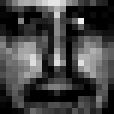

In [29]:
X = readdlm("nnmf-2429-by-361-face.txt")
colorview(Gray, reshape(X[1, :], 19, 19))

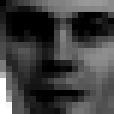

In [30]:
colorview(Gray, reshape(X[10, :], 19, 19))

### Q1.3 Correctness and efficiency

Report the run times, using `@btime`, of your function for fitting NNMF on the MIT CBCL face data set at ranks $r=10, 20, 30, 40, 50$. For ease of comparison (and grading), please start your algorithm with the provided $\mathbf{V}^{(0)}$ (first $r$ columns of [`V0.txt`](https://raw.githubusercontent.com/ucla-biostat-257/2024spring/master/hw/hw2/V0.txt)) and $\mathbf{W}^{(0)}$ (first $r$ rows of [`W0.txt`](https://raw.githubusercontent.com/ucla-biostat-257/2024spring/master/hw/hw2/W0.txt)) and stopping criterion
$$
\frac{|L^{(t+1)} - L^{(t)}|}{|L^{(t)}| + 1} \le 10^{-4}.
$$

**Hint**: When I run the following code using my own implementation of `nnmf`
```julia
# provided start point
V0full = readdlm("V0.txt", ' ', Float64)
W0full = readdlm("W0.txt", ' ', Float64);

# benchmarking
for r in [10, 20, 30, 40, 50]
    println("r=$r")
    V0 = V0full[:, 1:r]
    W0 = W0full[1:r, :]
    _, _, obj, niter = nnmf(X, r, V = V0, W = W0)
    @btime nnmf($X, $r, V = $V0, W = $W0) setup=(
        copyto!(V0, V0full[:, 1:r]), 
        copyto!(W0, W0full[1:r, :])
        )
    println("obj=$obj, niter=$niter")
end
```
the output is
```
r=10
  162.662 ms (9 allocations: 437.19 KiB)
obj=11730.866905748058, niter=239
r=20
  234.293 ms (9 allocations: 875.44 KiB)
obj=8497.605595863002, niter=394
r=30
  259.524 ms (9 allocations: 1.28 MiB)
obj=6621.94596847528, niter=482
r=40
  289.918 ms (9 allocations: 1.72 MiB)
obj=5256.866299829562, niter=581
r=50
  397.511 ms (10 allocations: 2.15 MiB)
obj=4430.362097310877, niter=698
```
Due to machine differences, your run times can be different from mine but certainly can not be order of magnitude longer. Your memory allocation should be less or equal to mine.

**Solution**

Note that running Q1.4 with $r = 20, 30, 40, 50$ earlier gives an error in running Q1.3 and then running Q1.3 works after running Q1.4 in $r = 10$ for some reason.

In [33]:
# provided start point
V0full = readdlm("V0.txt", ' ', Float64)
W0full = readdlm("W0.txt", ' ', Float64);

# benchmarking
for r in [10, 20, 30, 40, 50]
    println("r=$r")
    V0 = V0full[:, 1:r]
    W0 = W0full[1:r, :]
    _, _, obj, niter = nnmf(X, r, V = V0, W = W0)
    @btime nnmf($X, $r, V = $V0, W = $W0) setup=(
        copyto!(V0, V0full[:, 1:r]), # use $r resolves unknown error
        copyto!(W0, W0full[1:r, :])
        )
    println("obj = $obj, niter = $niter")
end

r=10
  247.591 ms (9 allocations: 437.31 KiB)
obj = 11730.388009854098, niter = 239
r=20
  318.398 ms (9 allocations: 875.81 KiB)
obj = 8497.222317849722, niter = 394
r=30
  500.289 ms (9 allocations: 1.28 MiB)
obj = 6621.6273454855545, niter = 482
r=40
  411.256 ms (9 allocations: 1.72 MiB)
obj = 5256.663870562974, niter = 581
r=50
  554.087 ms (10 allocations: 2.15 MiB)
obj = 4430.201581697111, niter = 698


The objective values were comparable to, and slightly better than, his results with the same number of iterations. Additionally, my memory allocation and usage matched his. 

### Q1.4 Non-uniqueness

Choose an $r \in \{10, 20, 30, 40, 50\}$ and start your algorithm from a different $\mathbf{V}^{(0)}$ and $\mathbf{W}^{(0)}$. Do you obtain the same objective value and $(\mathbf{V}, \mathbf{W})$? Explain what you find.

**Solution**

Choose $r = 50$ for Q1.6. First, we start with the original $\mathbf{V}^{(0)}$ and $\mathbf{W}^{(0)}$ to obtain the objective value and $(\mathbf{V}, \mathbf{W})$ as `V1` and `W1`.

In [11]:
r = 50
println("r = $r")
V0 = V0full[:, 1:r]
W0 = W0full[1:r, :]
V1, W1, obj, niter = nnmf(X, r, V = V0, W = W0)
# @btime nnmf($X, $r, V = $V0, W = $W0) setup=(
#     copyto!(V0, V0full[:, 1:r]), 
#     copyto!(W0, W0full[1:r, :])
#     )
println("obj = $obj, niter = $niter")
# display(V1)
# display(W1)

r = 50
obj = 4430.201581697111, niter = 698


Next, I create different $\mathbf{V}^{(0)}$ and $\mathbf{W}^{(0)}$ whose elements are randomly chosen from $\text{U}(0, 1)$ and then run algorithm with $r = 50$.

In [12]:
r = 50
println("r = $r")
Random.seed!(257)
V0 = Random.rand!(similar(X, size(X, 1), r))
W0 = Random.rand!(similar(X, r, size(X, 2)))
V2, W2, obj, niter = nnmf(X, r, V = V0, W = W0)
# @btime nnmf($X, $r, V = $V0, W = $W0)
println("obj = $obj, niter = $niter")
# display(V2)
# display(W2)

r = 50
obj = 4446.331825885412, niter = 691


We obtained a slightly larger objective value and a different iteration number. As expected from the difference in `obj`, the two sets of $(\mathbf{V}, \mathbf{W})$ were also different as follows.

In [28]:
# check the difference at different levels of tolerance
isapprox(V1, V2, atol = 1e-2) && isapprox(W1, W2, atol = 1e-2),
isapprox(V1, V2, atol = 1e-1) && isapprox(W1, W2, atol = 1e-1)

(false, false)

Since $L(\mathbf{V}, \mathbf{W})$ is *not* a convex function, obtaining a larger objective value indicates that these starting points led to a local minimum.

### Q1.5 Fixed point

For the same $r$, start your algorithm from $v_{ik}^{(0)} = w_{kj}^{(0)} = 1$ for all $i,j,k$. Do you obtain the same objective value and $(\mathbf{V}, \mathbf{W})$? Explain what you find.

**Solution**

In [31]:
r = 50
println("r = $r")
V0 = ones(size(X, 1), r)
W0 = ones(r, size(X, 2))
V3, W3, obj, niter = nnmf(X, r, V = V0, W = W0)
println("obj = $obj, niter = $niter")
# display(V3)
# display(W3)

r = 10
obj = 25297.01651108099, niter = 3


In [14]:
isapprox(V1, V3, atol = 1e-0) && isapprox(W1, W3, atol = 1e-0)

false

The objective value and $(\mathbf{V}, \mathbf{W})$ were completely different from the originals due to the identifiability issue.

### Q1.6 Interpret NNMF result

Plot the basis images (rows of $\mathbf{W}$) at rank $r=50$. What do you find?

**Solution**

Recall that I stored the original $\mathbf{W}$ for $r = 50$ as `W1`, which can be used here.

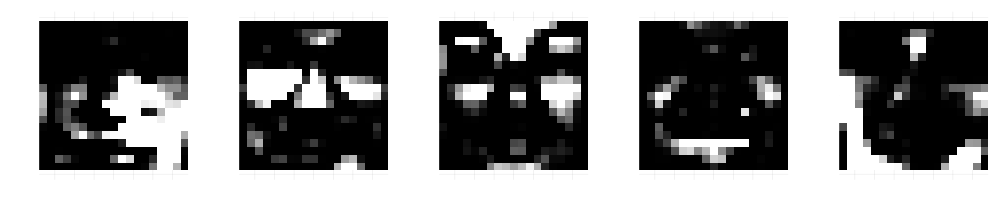

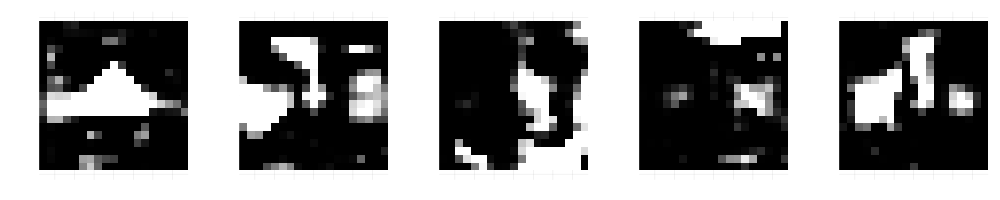

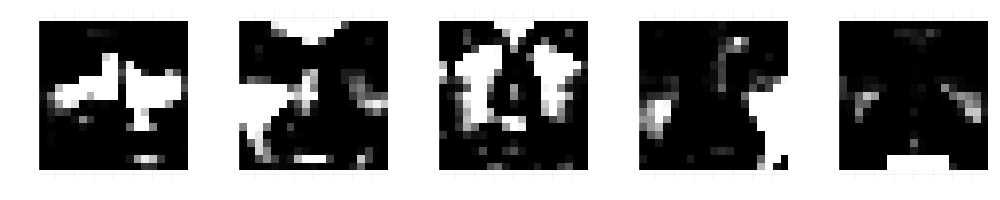

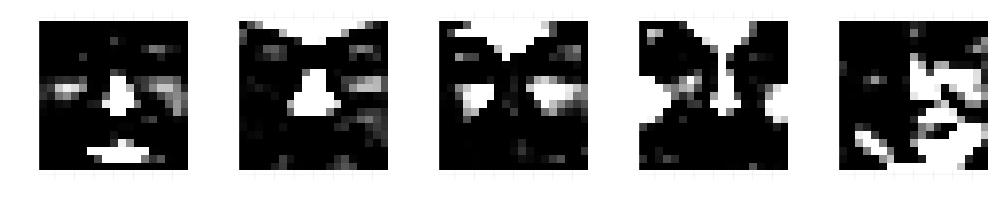

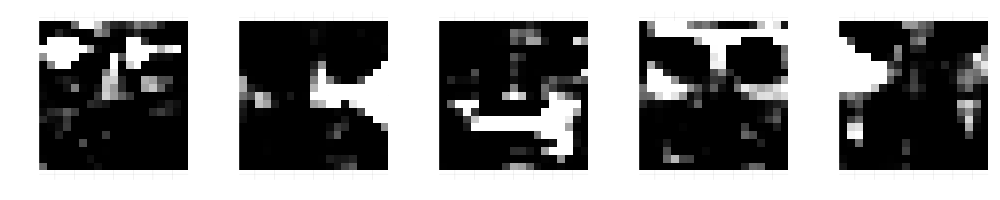

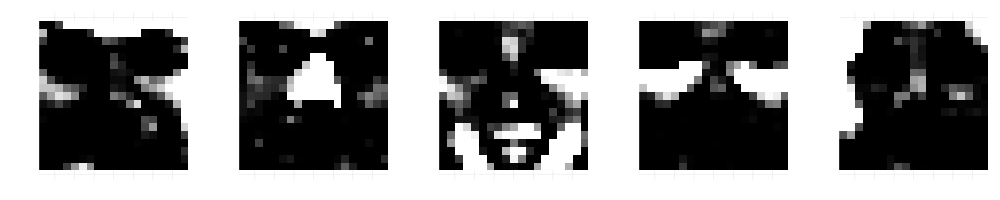

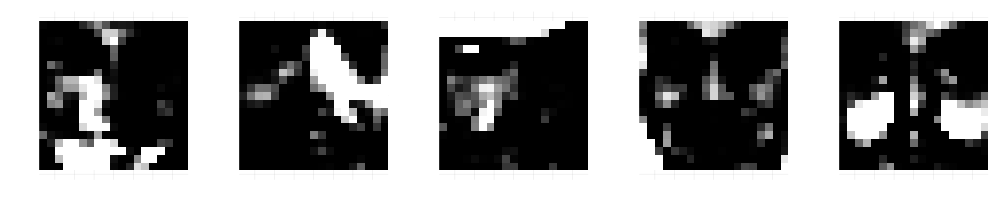

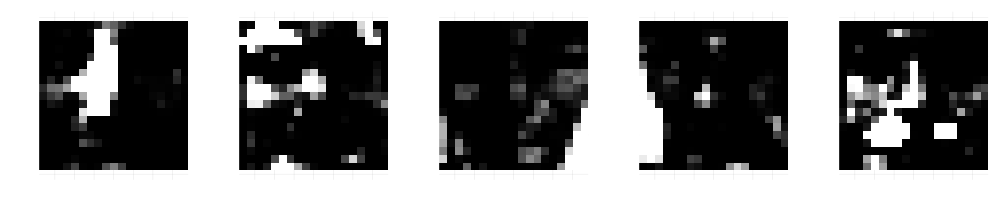

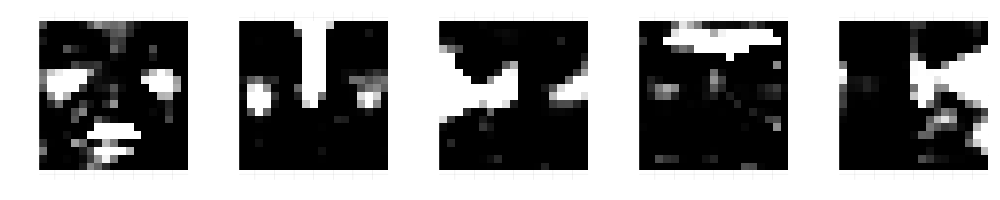

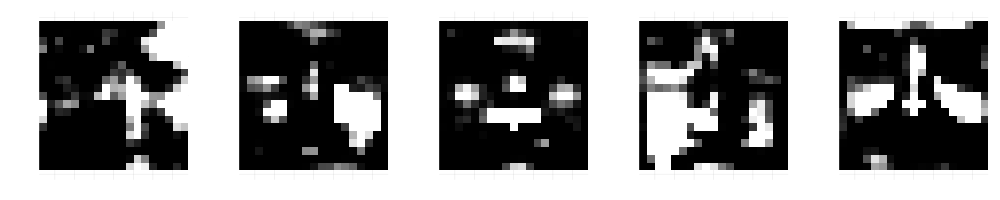

In [15]:
images = [colorview(Gray, reshape(W1[i, :], 19, 19)) for i in 1:50]

for i in 1:5:46
    p = plot(layout = (1, 5), size = (1000, 200)) 
    for j in i:(i + 4)
        heatmap!(p, images[j], c = :grays, axis = false, subplot = (j - i + 1))  
    end
    display(p)
end 

Each row in $\mathbf W$ seems to represent a part of the original face.

### Q1.7 GPU (optional)

Investigate the GPU capabilities of your computer. Report the speed gain of your GPU code over CPU code at ranks $r=10, 20, 30, 40, 50$. Make sure to use the same starting point as in Q1.3.

In [16]:
using Metal
Metal.versioninfo()

macOS 14.1.2, Darwin 23.1.0

Toolchain:
- Julia: 1.10.2
- LLVM: 15.0.7

Julia packages: 
- Metal.jl: 1.1.0
- LLVMDowngrader_jll: 0.1.0+1

1 device:
- Apple M1 (64.000 KiB allocated)


**Solution**

Here is my GPU code.

In [17]:
function nnmf_GPU(
    # positional arguments
    X       :: AbstractMatrix{T}, 
    r       :: Integer;
    # kw arguments
    maxiter :: Integer = 1000, 
    tolfun  :: Number = 1e-4,
    V       :: AbstractMatrix{T} = Metal.rand(Float32, size(X, 1), r),
    W       :: AbstractMatrix{T} = Metal.rand(Float32, r, size(X, 2)),
    ) where T <: AbstractFloat
    
    # preallocate necessary matrices on the GPU
    temp   = Metal.zeros(Float32, r, r) # WWt or VtV
    XWt    = Metal.zeros(Float32, size(X, 1), r) # for update V 
    VWWt   = Metal.zeros(Float32, size(X, 1), r) # for update V
    VtX    = Metal.zeros(Float32, r, size(X, 2)) # for update W and obj
    VtVW   = Metal.zeros(Float32, r, size(X, 2)) # for update W and obj
    
    # obj at start point
    normXsq = dot(X, X) # norm(X)^2 looks a bit slower?
    mul!(temp, transpose(V), V) # VtV here
    mul!(VtVW, temp, W) 
    mul!(VtX, transpose(V), X)
    obj = normXsq - 2dot(W, VtX) + dot(VtVW, W)
        
    niter = 0
    
    for iter in 1:maxiter

        mul!(XWt, X, transpose(W))
        mul!(temp, W, transpose(W)) # WWt here
        mul!(VWWt, V, temp)
        
        # update V
        @. V *= XWt / VWWt

        mul!(VtX, transpose(V), X)
        mul!(temp, transpose(V), V) # VtV here
        mul!(VtVW, temp, W)

        # update W
        @. W *= VtX / VtVW

        mul!(VtVW, temp, W)

        # update obj
        obj_old = obj
        obj = normXsq - 2dot(W, VtX) + dot(VtVW, W)

        # convergence check
        if abs(obj - obj_old) < tolfun * (abs(obj_old) + 1)
            niter = iter
            break
        end
    end
    # Output
    V, W, obj, niter
end

nnmf_GPU (generic function with 1 method)

Implement GPU code. To avoid unknown errors, we commented out `copyto!(V0, V0full[:, 1:r]); copyto!(W0, W0full[1:r, :])`.

In [20]:
X = MtlArray(Float32.(readdlm("nnmf-2429-by-361-face.txt")))
V0full = MtlArray(Float32.(readdlm("V0.txt")))
W0full = MtlArray(Float32.(readdlm("W0.txt")));

for r in [10, 20, 30, 40, 50]
    println("r = $r")
    V0 = V0full[:, 1:r]
    W0 = W0full[1:r, :]
    _, _, obj, niter = nnmf_GPU(X, r, V = V0, W = W0)
    @btime begin Metal.@sync nnmf_GPU($X, $r, V = $V0, W = $W0) end setup=(
        copyto!(V0, V0full[:, 1:$r]), # add $ to avoid an issue
        copyto!(W0, W0full[1:$r, :])
        )
    println("obj = $obj, niter = $niter")
end


r = 10
  674.126 ms (349398 allocations: 8.50 MiB)
obj = 11731.57, niter = 238
r = 20
  1.602 s (797245 allocations: 19.89 MiB)
obj = 8496.406, niter = 395
r = 30
  1.878 s (930057 allocations: 23.21 MiB)
obj = 6635.7188, niter = 461
r = 40
  2.536 s (1157032 allocations: 28.87 MiB)
obj = 5260.3984, niter = 574
r = 50
  3.185 s (1394246 allocations: 34.79 MiB)
obj = 4432.9062, niter = 692


Implement my CPU code again with the same comment out. For fair comparison, all matrices change to single precision, like GPU code.

In [21]:
X = readdlm("nnmf-2429-by-361-face.txt", ' ', Float32)
V0full = readdlm("V0.txt", ' ', Float32)
W0full = readdlm("W0.txt", ' ', Float32);

for r in [10, 20, 30, 40, 50]
    println("r = $r")
    V0 = V0full[:, 1:r]
    W0 = W0full[1:r, :]
    _, _, obj, niter = nnmf(X, r, V = V0, W = W0)
    @btime nnmf($X, $r, V = $V0, W = $W0) setup=(
        copyto!(V0, V0full[:, 1:$r]),
        copyto!(W0, W0full[1:$r, :])
        )
    println("obj = $obj, niter = $niter")
end

r = 10
  214.742 ms (7 allocations: 219.33 KiB)
obj = 11731.328, niter = 238
r = 20
  479.207 ms (9 allocations: 438.20 KiB)
obj = 8496.156, niter = 395
r = 30
  771.544 ms (9 allocations: 658.19 KiB)
obj = 6652.5625, niter = 437
r = 40
  991.349 ms (9 allocations: 878.94 KiB)
obj = 5263.4766, niter = 568
r = 50
  1.404 s (9 allocations: 1.07 MiB)
obj = 4460.6094, niter = 634


<!-- We see that GPU code took slightly faster with $r= 40, 50$ than CPU code, although it used much larger allocations and memory usage. But if I commented out `copyto!(V0, V0full[:, 1:r]); copyto!(W0, W0full[1:r, :])`, then GPU code uses smaller memory usage compared to CPU code. -->

Unfortunately, I was unable to achieve faster performance with the GPU code compared to the CPU code for any value of $r$. This would make sense at least on my computer, where the difference in efficiency between dot products and broadcasting is minimal even high demensional data, unlike the substantial difference Dr. Zhou demonstrated in the lecture.

In [22]:
Random.seed!(257)

n = 2^14 # high demension
# on CPU
x = rand(Float32, n, n)
y = rand(Float32, n, n)
z = zeros(Float32, n, n)
# on GPU
xd = MtlArray(x)
yd = MtlArray(y)
zd = MtlArray(z);

6.1 Dot product

In [78]:
# GPU
bm_gpu = @benchmark Metal.@sync dot($xd, $yd)

BenchmarkTools.Trial: 123 samples with 1 evaluation.
 Range (min … max):  37.032 ms … 94.403 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     39.260 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   40.637 ms ±  5.953 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

    ██▇▆▅▄                                                     
  ▆████████▇▇▇▃▅█▆▃▁▁▁▁▄▁▃▁▃▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▁▁▃ ▃
  37 ms           Histogram: frequency by time        58.5 ms <

 Memory estimate: 26.30 KiB, allocs estimate: 956.

In [75]:
# CPU
bm_cpu = @benchmark $z .= $x .* $y

BenchmarkTools.Trial: 69 samples with 1 evaluation.
 Range (min … max):  60.759 ms … 389.381 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     63.372 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   73.226 ms ±  53.453 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █▁                                                            
  ██▆▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄ ▁
  60.8 ms       Histogram: log(frequency) by time       370 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [79]:
# speedup
median(bm_cpu.times) / median(bm_gpu.times)

1.614167936344508

His result was 4.844882645493413.

6.2 Broadcast

In [80]:
# GPU
bm_gpu = @benchmark Metal.@sync $zd .= $xd .* $yd

BenchmarkTools.Trial: 83 samples with 1 evaluation.
 Range (min … max):  56.494 ms … 124.309 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     58.728 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   60.557 ms ±   7.790 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▂ ▂ ▂▅█▅▂                                                     
  █▇█▅█████▇▇▅▅█▇▇▁▄▅▄▁▅▄▁▁▁▄▁▁▁▁▄▁▄▁▁▁▄▁▁▁▁▁▁▁▁▁▁▁▅▁▁▁▁▁▁▁▁▁▄ ▁
  56.5 ms         Histogram: frequency by time         74.1 ms <

 Memory estimate: 5.33 KiB, allocs estimate: 196.

In [81]:
# CPU
bm_cpu = @benchmark $z .= $x .* $y

BenchmarkTools.Trial: 60 samples with 1 evaluation.
 Range (min … max):  65.901 ms … 203.090 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     74.324 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   84.159 ms ±  24.495 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

   ▂ █ ▆                                                        
  ██▅███▇█▅▄▄▅▁▁▁▄▁▁▄▁▁▁▁▄▄▅▄▁▁▄▁▄▁▄▁▁▁▄▁▁▁▄▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄ ▁
  65.9 ms         Histogram: frequency by time          154 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [82]:
median(bm_cpu.times) / median(bm_gpu.times)

1.2655493428436093

His result was 3.989440201602489.